In [ ]:
import numpy as np
import os
import matplotlib.pyplot as plt
from PIL import Image
import time 
import random
from IPython.display import clear_output
from keras.utils import to_categorical
from keras.preprocessing import image
import gc
import cv2

In [ ]:
scales = [(1024, 768), (512,384),(256,192)] # Размеры для последовательного уменьшения изображения
kernel = np.ones((1,1), np.uint8) # Размер фильтра

In [ ]:
# Функция перевода цвета пикселя в класс
def rgbToohe(y, num_classes):
  
  y2 = y.copy()
  y = y.reshape(y2.shape[0]*y2.shape[1], 3)
  yt = color2index(y, num_classes)
  yt = yt.reshape(y2.shape[0], y2.shape[1])

  return yt

In [ ]:
# Функция перевода rgb вектора в вектор значений класса
def color2index(color, num_classes):
  
  index = np.full((color.shape[0],1), num_classes-1)

  ind_floor = np.where((149>=color[:,0])&(color[:,0]>51) & (149>=color[:,1])&(color[:,1]>=51) & (149>=color[:,2])&(color[:,2]>=51))[0]
  ind_roof = np.where((49>=color[:,0])&(color[:,0]>=0) & (49>=color[:,1])&(color[:,1]>=0) & (149>=color[:,2])&(color[:,2]>=51))[0]
  ind_wall = np.where((49>=color[:,0])&(color[:,0]>=0) & (149>=color[:,1])&(color[:,1]>=51) & (49>=color[:,2])&(color[:,2]>=0))[0]
  ind_column = np.where((149 >=color[:,0])&(color[:,0]>=51) & (49>=color[:,1])&(color[:,1]>=0) & (49>=color[:,2])&(color[:,2]>=0))[0]
  ind_doorway = np.where((49>=color[:,0])&(color[:,0]>=0) & (149>=color[:,1])&(color[:,1]>=51) & (149>=color[:,2])&(color[:,2]>=51))[0]
  ind_door = np.where((100>=color[:,0])&(color[:,0]>=51) & (49>=color[:,1])&(color[:,1]>=0) & (149>=color[:,2])&(color[:,2]>=51))[0]
  ind_window = np.where((149>=color[:,0])&(color[:,0]>=51) & (149>=color[:,1])&(color[:,1]>=51) & (49>=color[:,2])&(color[:,2]>=0))[0]
  ind_outer_world = np.where((249>=color[:,0])&(color[:,0]>=151) & (249>=color[:,1])&(color[:,1]>=151) & (249>=color[:,2])&(color[:,2]>=151))[0]
  ind_stairs = np.where((49>=color[:,0])&(color[:,0]>=0) & (49>=color[:,1])&(color[:,1]>=0) & (249>=color[:,2])&(color[:,2]>=151))[0]
  ind_handrail = np.where((49>=color[:,0])&(color[:,0]>=0) & (249>=color[:,1])&(color[:,1]>=151) & (49>=color[:,2])&(color[:,2]>=0))[0]
  ind_battery = np.where((249>=color[:,0])&(color[:,0]>=151) & (49>=color[:,1])&(color[:,1]>=0) & (49>=color[:,2])&(color[:,2]>=0))[0]
  ind_people = np.where((49>=color[:,0])&(color[:,0]>=0) & (249>=color[:,1])&(color[:,1]>=151) & (249>=color[:,2])&(color[:,2]>=151))[0]
  ind_inventory = np.where((249>=color[:,0])&(color[:,0]>=100) & (49>=color[:,1])&(color[:,1]>=0) & (249>=color[:,2])&(color[:,2]>=151))[0]
  ind_light = np.where((249>=color[:,0])&(color[:,0]>=151) & (249>=color[:,1])&(color[:,1]>=151) & (49>=color[:,2])&(color[:,2]>=0))[0]
  ind_wires = np.where((49>=color[:,0])&(color[:,0]>=0) & (149>=color[:,1])&(color[:,1]>=51) & (249>=color[:,2])&(color[:,2]>=151))[0]
  ind_balk = np.where((149>=color[:,0])&(color[:,0]>=51) & (49>=color[:,1])&(color[:,1]>=0) & (249>=color[:,2])&(color[:,2]>=151))[0]

  index[ind_floor] = 1
  index[ind_roof] = 2
  index[ind_wall] = 3
  index[ind_column] = 4
  index[ind_doorway] = 6
  index[ind_door] = 7
  index[ind_window] = 8
  index[ind_outer_world] = 0
  index[ind_stairs] = 9
  index[ind_handrail] = 10
  index[ind_battery] = 11
  index[ind_people] = 12
  index[ind_inventory] = 13
  index[ind_light] = 14
  index[ind_wires] = 15
  index[ind_balk] = 5

  return index

In [ ]:
def index2color(numpy_grid, num_classes, colors):

  '''
  Функция перевода индекса в RGB значение
  Входные параметры:
    - numpy_grid - 2D матрица значений индексов
    - num_classes - количество классов сегментации
    - colors - цвета классов в RGB  формате
  Выходные параметры:
    - output - RGB изображение карты сегментации
  '''

  index = numpy_grid.flatten()

  h = numpy_grid.shape[0]
  w = numpy_grid.shape[1]
  output = np.zeros(shape=(h*w, 3))

  for i in range(num_classes):
    indices = np.where(index == i)[0]
    output[indices] = colors[i]

  return output.reshape((h, w, 3))

colors = [[200, 200, 200],
          [100, 100, 100],
          [0, 0, 100],
          [0, 100, 0],
          [100, 0, 0],
          [100, 0, 200],
          [0, 100, 100],
          [100, 0, 100],
          [100, 100, 0],
          [0, 0, 200],
          [0, 200, 0],
          [200, 0, 0],
          [0, 200, 200],
          [200, 0, 200],
          [200, 200, 0],
          [0, 100, 200],
          [0, 0, 0]]

In [ ]:
def check_pixels(test_img):

    '''
    Функция для корректировки значений пикселя
    '''

    actions = [(-1,-1), (-1,0), (-1,1), (0,1), (1,1), (1,0), (1,-1), (0,-1)]
    
    for i in range(1, test_img.shape[0]-1):
        for j in range(1, test_img.shape[1]-1):
            point_surrounding = {k:0 for k in range(num_classes)}
            
            for act in actions:
                point_surrounding[test_img[i+act[0],j+act[1]]] += 1
                
            if point_surrounding[test_img[i,j]] < 2:
                test_img[i,j] = [k for k, v in sorted(point_surrounding.items(), key=lambda item: item[1], reverse=True)][0]
            if test_img[i,j] == 15 and point_surrounding[12] > 0 and point_surrounding[2] > 0:
                test_img[i,j] = 12
            if test_img[i,j] == 7 and point_surrounding[5] > 0 and point_surrounding[3] > 0:
                test_img[i,j] = 5
            if test_img[i,j] == 7 and point_surrounding[5] > 0 and point_surrounding[1] > 0:
                test_img[i,j] = 5
            if test_img[i,j] == 15 and point_surrounding[12] > 0 and point_surrounding[7] > 0:
                test_img[i,j] = 12
            if test_img[i,j] == 15 and point_surrounding[12] > 0 and point_surrounding[5] > 0:
                test_img[i,j] = 12
                
    return test_img

In [ ]:
def resize_image(img_class, num_classes):

    '''
    Функция для последовательного зжатия изображения
    '''
    
    img_resized = np.full(shape=(192, 256), fill_value=num_classes-1)

    for i in range(num_classes-1):
        test_img = img_class[i].copy()

        for j in range(len(scales)):

            test_img = cv2.resize(test_img, scales[j], cv2.INTER_AREA)
            test_img = cv2.dilate(test_img, kernel, iterations = 1)
        
        class_indices = np.where(test_img > 0)
        img_resized[class_indices] = i
    
    return img_resized

# Trian and Val

In [ ]:
image_height = 256
image_width = 192
directory = 'E:/NN/work/base_fixed/train/'
train_directory = 'xAll/'
train_directory_seg = 'yAll/'

num_classes = 17

In [ ]:
# Считываем базу изображений
train_images = []

curr_time = time.time()
for filename in sorted(os.listdir(f'{directory}/{train_directory}')):
  img = image.load_img(f'{directory}/{train_directory}/{filename}', 
                       target_size=(image_width,image_height))
  img = image.img_to_array(img=img)
  train_images.append(img)
  
print(f'Train images ready, time {round(time.time() - curr_time)} s')

Train images ready, time 134 s


In [ ]:
# Считываем базу карт сегментации
filenames = sorted(os.listdir(os.path.join(directory, train_directory_seg)))
train_segments = []

curr_time = time.time()
for filename in filenames:
    # Считываем изображение и переводим цвета в индексы
    path = os.path.join(directory, train_directory_seg, filename)
    img = cv2.imread(path)
    img = img[:,:,::-1]
    img_classes = to_categorical(rgbToohe(img, num_classes), num_classes)
    
    # Получаем бинарные карты для каждого класса
    img_class = []
    for i in range(img_classes.shape[2]):
        img_class.append(img_classes[:,:,i])
    
    # Итеративно уменьшаем размеры изображения
    img_resized = resize_image(img_class, num_classes)
    # Корректируем значения пикселей
    img_resized = check_pixels(img_resized)
    # Переводим изображение в RGB формат
    img_final = index2color(img_resized, num_classes, colors)
    
    train_segments.append(img_final.astype(np.uint8))
    
    if len(train_segments_crop) % 100 == 0:
        print(f'{len(train_segments_crop)} time {round(time.time() - curr_time)} s')
    
print(f'Train images ready, time {round(time.time() - curr_time)} s')

100 time 301 s
200 time 600 s
300 time 898 s
400 time 1196 s
500 time 1494 s
600 time 1794 s
700 time 2090 s
800 time 2388 s
900 time 2449 s
1000 time 2506 s
1100 time 2562 s
1200 time 2618 s
1300 time 2675 s
1400 time 2732 s
1500 time 2789 s
1600 time 2847 s
Train images ready, time 2847 s


In [ ]:
np.savez('E:/NN/work/base_fixed/baza_train_2.npz',
         xTrain=np.array(train_images),
         yTrain=np.array(train_segments))

Проверим результаты

In [ ]:
loaded_train = np.load('E:/NN/work/base_fixed/baza_train_2.npz')
print(loaded_train.files)
train_images = loaded_train['xTrain'] # Оригинальные картинки
print(train_images.shape)
train_segments = loaded_train['yTrain'] # Сегментированные маски
print(train_segments.shape)
print('База прочитана')

image_height = train_images.shape[1]
image_width  = train_images.shape[2]

segments_height = train_images.shape[1]
segments_width  = train_images.shape[2]

print(image_height, image_width, segments_height, segments_width)

['xTrain', 'yTrain']
(1600, 192, 256, 3)
(1600, 192, 256, 3)
База прочитана
192 256 192 256


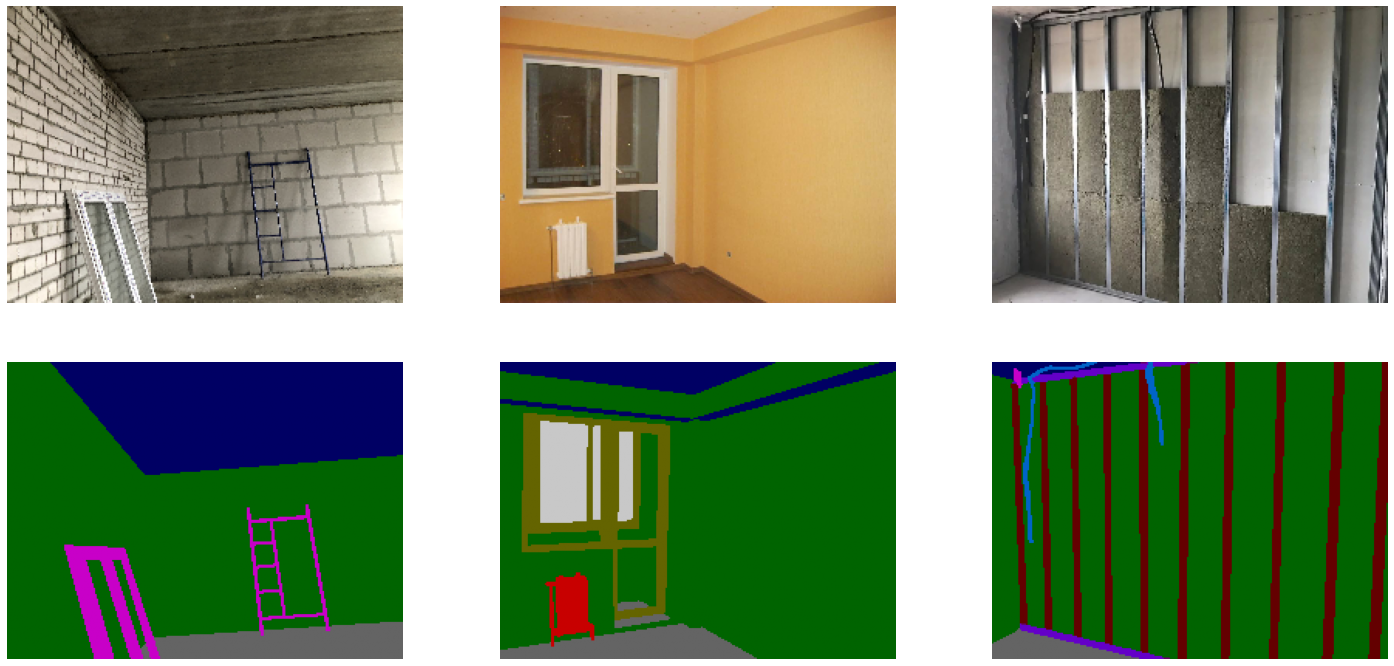

In [ ]:
indices = np.random.randint(0, len(train_images), 3)
fig, ax = plt.subplots(2, len(indices), figsize=(25, 12))
for i, ind in enumerate(indices):
  ax[0,i].imshow(train_images[ind] / 255)
  ax[0,i].axis('off')
  ax[1,i].imshow(train_segments[ind] / 255)
  ax[1,i].axis('off')
plt.show()

In [ ]:
image_height = 256
image_width = 192
directory = 'E:/NN/work/base_fixed/val/'
train_directory = 'xAll'
train_directory_seg = 'yAll'

num_classes = 17

In [ ]:
# Считываем базу изображений
test_images = []

curr_time = time.time()
for filename in sorted(os.listdir(f'{directory}/{train_directory}')):
  img = image.load_img(f'{directory}/{train_directory}/{filename}', 
                       target_size=(image_width,image_height))
  img = image.img_to_array(img=img)
  test_images.append(img)
  
print(f'Train images ready, time {round(time.time() - curr_time)} s')

Train images ready, time 36 s


In [ ]:
# Считываем базу карт сегментации
filenames = sorted(os.listdir(os.path.join(directory, train_directory_seg)))
test_segments = []

curr_time = time.time()
for filename in filenames:
    # Считываем изображение и переводим цвета в индексы
    path = os.path.join(directory, train_directory_seg, filename)
    img = cv2.imread(path)
    img = img[:,:,::-1]
    img_classes = to_categorical(rgbToohe(img, num_classes), num_classes)

    # Получаем бинарные карты для каждого класса
    img_class = []
    for i in range(img_classes.shape[2]):
        img_class.append(img_classes[:,:,i])

    # Итеративно уменьшаем размеры изображения
    img_resized = resize_image(img_class, num_classes)
    # Корректируем значения пикселей
    img_resized = check_pixels(img_resized)
    # Переводим изображение в RGB формат
    img_final = index2color(img_resized, num_classes, colors)
    
    test_segments.append(img_final.astype(np.uint8))
    
    if len(test_segments_crop) % 100 == 0:
        print(f'time {round(time.time() - curr_time)} s')
    
print(f'Train images ready, time {round(time.time() - curr_time)} s')

time 300 s
time 591 s
time 648 s
time 704 s
Train images ready, time 704 s


In [ ]:
np.savez('E:/NN/work/base_fixed/baza_test_2.npz',
         xTest=np.array(test_images),
         yTest=np.array(test_segments))

Проверим результаты

In [ ]:
loaded_train = np.load('E:/NN/work/base_fixed/baza_test_2.npz')
print(loaded_train.files)
train_images = loaded_train['xTest'] # Оригинальные картинки
print(train_images.shape)
train_segments = loaded_train['yTest'] # Сегментированные маски
print(train_segments.shape)
print('База прочитана')

image_height = train_images.shape[1]
image_width  = train_images.shape[2]

segments_height = train_images.shape[1]
segments_width  = train_images.shape[2]

print(image_height, image_width, segments_height, segments_width)

['xTest', 'yTest']
(400, 192, 256, 3)
(400, 192, 256, 3)
База прочитана
192 256 192 256


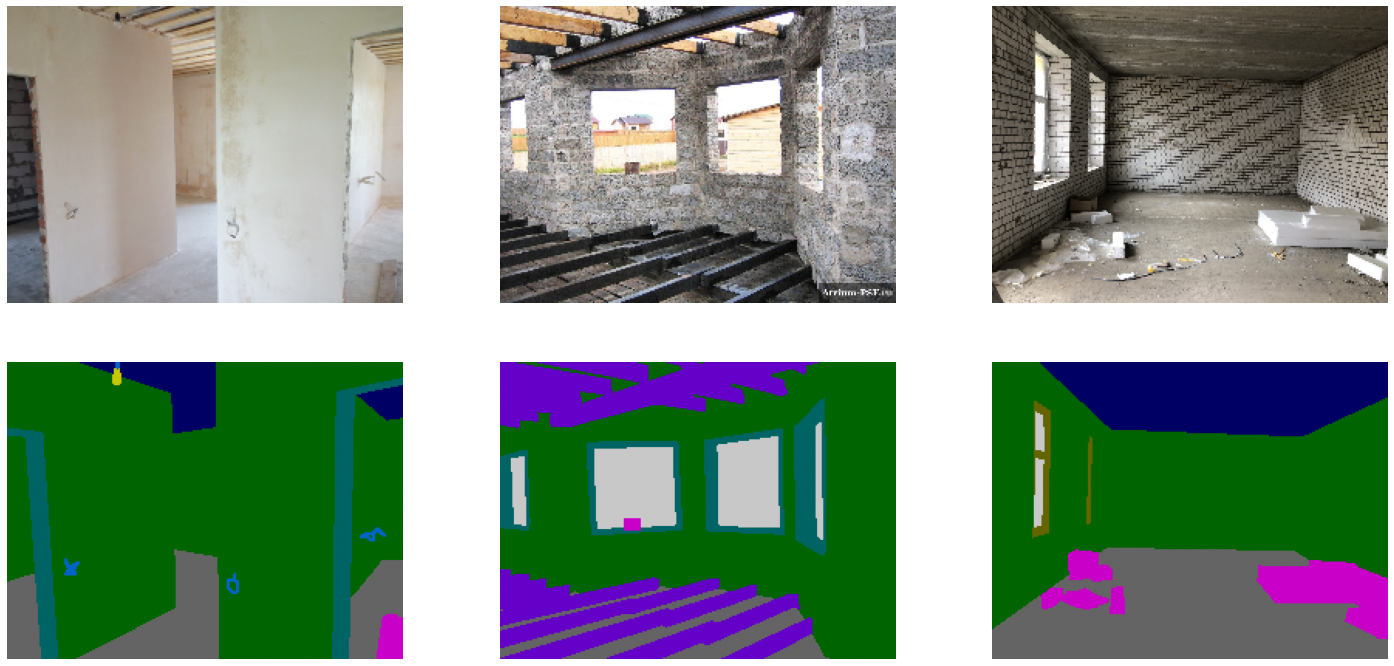

In [ ]:
indices = np.random.randint(0, len(train_images), 3)
fig, ax = plt.subplots(2, len(indices), figsize=(25, 12))
for i, ind in enumerate(indices):
  ax[0,i].imshow(train_images[ind] / 255)
  ax[0,i].axis('off')
  ax[1,i].imshow(train_segments[ind] / 255)
  ax[1,i].axis('off')
plt.show()